In [1]:
#example

# Example: MNIST with Babilim

> A babilim example to solve fashion MNIST with a gpu.


**Before we start. This tutorial is not the shortest possible MNIST implementation, but serves as a template on how to approach your own deep learning project.
Any deep learning project is typically best implemented in this order presented here and with a similar structure.**

This makes this tutorial longer than nescessary, however since there are many MNIST examples, we wanted to make ours a tutorial on how to approach any deep learning project.

You can find the code of this notebook nicely separated into multiple files [here (github/babilim-mnist)](https://github.com/penguinmenac3/babilim-mnist).


## Installation Instructions

**Make sure you have installed babilim and pytorch or tf2.**

```bash
conda activate my_env_name

# Install PyTorch/Tensorflow 2
# Follow instructions here for pytorch: https://pytorch.org/get-started/locally/
# Follow instructions here for tf2: https://www.tensorflow.org/install

# Then install babilim
pip install babilim
```

When you have additional requirements. Add them in a `requirements.txt` at the root of your project.

Example: `requirements.txt`

```
# Deep Learning Libraries
babilim
tensorflow  # in case you use tensorflow

# Other libraries
my_fancy_lib
```


### Import and Initialize Babilim

**After installing, the easiest way to see if the installation works is to import babilim and initialize it.**
We setup babilim to use the backend of choice in our notebook and set the debug verbosity to true.
A setting debug verbosity to true makes babilim output a lot of messages, but helps with debugging your code.

Once you just want to run your code debug verbosity false is recommended.

In [2]:
import os
import babilim
from babilim.core import logging

logging.DEBUG_VERBOSITY = True
logging.set_logger(os.path.join("logs", logging.get_timestamp() + "_FashionMNIST", "log.txt"))

babilim.set_backend(babilim.AUTO_BACKEND)

[2020-08-04 17:32:34] INFO Using backend: pytorch-gpu


## Defining the Problem

**When you start solving any deep learning task, the first thing you do is to think of what problem you are actually solving. Hence you should start by doing your problem definition.**

MNIST contains images of numbers 0-9.
The images are grayscale and have a resolution of 28x28.
For every image the number that has been written is annotated as an integer number.

We want to build a neural network that predicts the number given the image.
Typically the input to the neural network can be called features or image (we chose features, since it is more generic here).
The output in this case can be seen as a classification problem.
We have classes from 0  to 9 which are mutually exclusive, since a prediction can be only one number.
However classes should be prefered over regression, since they can model uncertainty between 8 and 2 better by assigning both high probabilities, whereas regression would yield 5 (which is completely wrong).

Those decisions lead to a problem definition as follows:

$
\texttt{image} \rightarrow \texttt{class-id}
$

In [3]:
# e.g.: definitions/mnist.py
from collections import namedtuple

# Create some named tuple for our inputs and outputs so we do not confuse them.
NetworkInput = namedtuple("NetworkInput", ["image"])
NetworkOutput = namedtuple("NetworkOutput", ["class_id"])

## Defining a Configuration

**Whereas we anticipate running multiple experiments over the course of the development, we want to have all configuration choices in one config class, so we can easily track the experiments.** All your typical *hyperparameters* and other parameters live in this configuration. The configuration is a python class, so you can make use of this by using inheritance.

At the beginning this class will be created empty and then filled with life over time.
In this example it will directly come with all variables required, since this cell has been edited multiple times during the development process.



In [4]:
# e.g.: configs/mnist.py
from babilim.core import Config
from babilim.training.optimizers import learning_rates


class FashionMnistConfig(Config):
    def __init__(self):
        super().__init__()
        self.problem_number_of_categories = 10
        self.problem_samples = 60000
        self.problem_base_dir = "datasets"

        self.train_epochs = 10
        self.train_l2_weight = 0.01
        self.train_batch_size = 32
        iterations_per_epoch = self.problem_samples / self.train_batch_size
        self.train_learning_rate_shedule = learning_rates.Exponential(initial_lr=0.001, k=0.1 / iterations_per_epoch)


# Create a config (should be in your main function)
config = FashionMnistConfig()

## Trinity of Dataset, Model, Trainer

**In every deep learning problem there is the trinity of the dataset, the model and the trainer.
If any of the parts is weak, the overall result will be unsatisfactory.**

This means we want to ensure that all parts work equally good.
Without good data, a good model is of no use at all.
So  we will start with the dataset and explore it.

This is typically a good way to start, whereas model choice is dependant on the data.

## Dataset

**The dataset class manages loading of your data in a format that is common and understandable. Transformers, then transform the data in a format that the neural network requires.**

In the case of MNIST we are in a comfortable spot, whereas the dataset is already balanced, and nicely preprocessed.
All images are centered, have the same size and have good contrast.
For the transformer the only thing left is therefore to wrap the numpy image into the tensorformat (e.g. change channel order for pytorch).

The dataset can be easily implemented using tensorflow and pytorch libraries, whereas they provide loaders for the data already.
This gives us a chance to show writing specific code for a backend.

In [5]:
# e.g.: datasets/mnist.py
import babilim
import numpy as np
from babilim import TF_BACKEND, SPLIT_TRAIN
from babilim.data import Dataset
from typing import Tuple


class FashionMnistDataset(Dataset):
    def __init__(self, config: FashionMnistConfig, split: str):
        super().__init__(config)
        if babilim.is_backend(TF_BACKEND):
            from tensorflow.keras.datasets import fashion_mnist
            (train, dev) = fashion_mnist.load_data()
            if split == SPLIT_TRAIN:
                self.dataset = list(zip(*train))
            else:
                self.dataset = list(zip(*dev))
        else:
            from torchvision.datasets import FashionMNIST
            self.dataset = FashionMNIST(config.problem_base_dir, train=split==SPLIT_TRAIN, download=True)

    def __len__(self) -> int:
        return int(len(self.dataset))

    def getitem(self, idx: int) -> Tuple[NetworkInput, NetworkOutput]:
        image, label = self.dataset[idx]
        image = np.array(image, dtype="float32")
        label = np.array(label, dtype="uint8")
        
        image = np.reshape(image, (28, 28))
        return NetworkInput(image=image), NetworkOutput(class_id=label)

    @property
    def version(self) -> str:
        return "FashionMnistDataset"

Now we will write a simple transformer that makes the data readable for the neural network training.

The transformer will make an image grid out of the feature, so it can be used in tensorflow or pytorch, since one has channel first and the other channel last representation.

In [6]:
# e.g.: datasets/mnist_transformers.py
from babilim.data import Transformer, image_grid_wrap
from typing import Tuple


class MNISTTransformer(Transformer):
    def __init__(self):
        pass
    
    def __call__(self, inp: NetworkInput, outp: NetworkOutput) -> Tuple[NetworkInput, NetworkOutput]:
        return NetworkInput(image=image_grid_wrap(inp.image)), outp
    
    @property
    def version(self):
        return "MNISTTransformer"

The dataset is created and then a transformer is appended to the transformers.
There are two types of transformers: `dataset::transformers` and `dataset::realtime_transformers`.
The difference between the two is that the realtime_transformers get applied after caching and the transformers before caching.

> Important: Realtime transformers should contain easy and quick computations to avoid slowing down your training and data augmentation should be done in realtime transformers or it will only be applied once (before caching).

In [7]:
# Create the dataset and setup the transformers (should be in your main function)
from babilim import SPLIT_TRAIN, SPLIT_DEV


data_train = FashionMnistDataset(config, SPLIT_TRAIN)
data_dev = FashionMnistDataset(config, SPLIT_DEV)
transformer = MNISTTransformer()
data_train.realtime_transformers.append(transformer)
data_dev.realtime_transformers.append(transformer)

One last step is to test if the dataset works.
To test this we will call the dataset with multiple random indices.
(The images you will see when executing might differ.)
Normally this test would be much more detailed, checking the value ranges of your data, if everything is aligned and as expected, but in this simple example we will only do a visual inspection.

In [8]:
# e.g. tests/mnist_visualization.py
import matplotlib.pyplot as plt
import random
from babilim.data import image_grid_unwrap
from babilim.core.logging import log_image

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    x = np.array(x)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def visualize(data, model, title, fname):
    print(title)
    plt.figure(figsize=(16,6))
    for i in range(24):
        idx = random.randint(0, len(data))
        feat, label = data[idx]
        class_probs = label.class_id
        if model is not None:
            pred = model.predict(image=feat.image)
            class_probs = softmax(pred.class_id)
            class_probs = ", ".join(["{:.0f}".format(x*100) for x in class_probs])
        plt.subplot(3, 8, i + 1)
        plt.axis('off')
        plt.title(class_probs)
        plt.imshow(image_grid_unwrap(feat.image)[:,:,0], cmap='gray', vmin=0, vmax=255)
    log_image(name=fname)
    plt.show()

Train Split


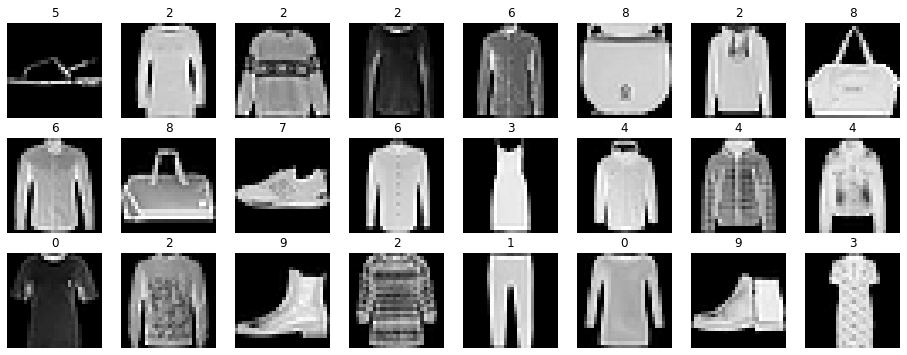

Dev Split


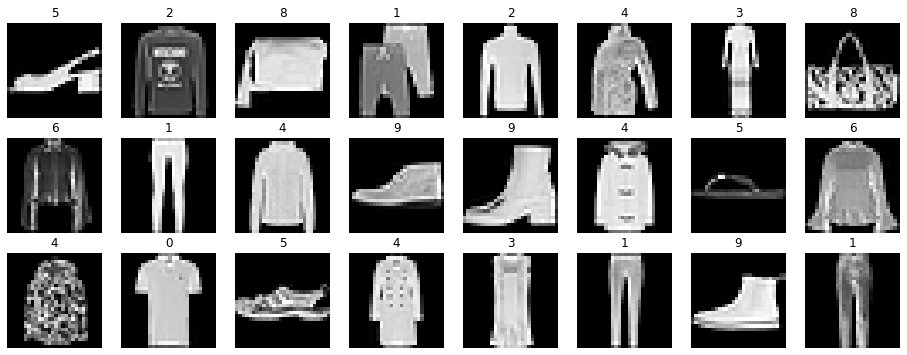

In [9]:
visualize(data_train, None, "Train Split", "training_data.png")
visualize(data_dev, None, "Dev Split", "dev_data.png")

## The Model

After having implemented and tested the dataloader.
We can move to the next step: Implementing the model.

This will actually be a suprisingly small part of this tutorial, since it is so easy with modern frameworks.

### CNN

The problem is classifying images into the clothing type, therefore a convolutional neural network is the right model choice.
If you do not now what a CNN is, please refer to one of the plenty resources available on the internet.

We will use a CNN inspired by VGG 16.
So it wil have convolutions followed by a few fully connected layers.

### Implementation

The model has an `__init__`, a `build`, and a `call`-function that need to be implemented.

The `build`-function with the `@RunOnlyOnce`-annotation will be run only once and build the model initially.
It has available knowledge on the shape of the input tensors.

The `call`-function is the actual forward pass of the model and typically trivial to implement when using the build-call pattern.

In [10]:
# e.g. model/mnist.py
from babilim.core import ITensor, RunOnlyOnce, Module
from babilim.model.layers.activation import Activation
from babilim.model.layers.batch_normalization import BatchNormalization
from babilim.model.layers.convolution import Conv2D
from babilim.model.layers.flatten import Flatten
from babilim.model.layers.fully_connected import FullyConnected
from babilim.model.layers.pooling import GlobalAveragePooling2D, MaxPooling2D


class FashionMnistModel(Module):
    def __init__(self, config: FashionMnistConfig):
        super().__init__()
        self.config = config
        self.linear = []

    @RunOnlyOnce
    def build(self, image: ITensor):
        out_features = self.config.problem_number_of_categories

        self.linear.append(BatchNormalization())
        self.linear.append(Conv2D(filters=12, kernel_size=(3, 3)))
        self.linear.append(Activation("relu"))
        self.linear.append(MaxPooling2D())

        self.linear.append(BatchNormalization())
        self.linear.append(Conv2D(filters=18, kernel_size=(3, 3)))
        self.linear.append(Activation("relu"))
        self.linear.append(MaxPooling2D())

        self.linear.append(BatchNormalization())
        self.linear.append(Conv2D(filters=18, kernel_size=(3, 3)))
        self.linear.append(Activation("relu"))
        self.linear.append(MaxPooling2D())

        self.linear.append(BatchNormalization())
        self.linear.append(Conv2D(filters=18, kernel_size=(3, 3)))
        self.linear.append(Activation("relu"))
        self.linear.append(GlobalAveragePooling2D())

        self.linear.append(BatchNormalization())
        self.linear.append(Flatten())
        self.linear.append(FullyConnected(out_features=18))
        self.linear.append(Activation("relu"))
        self.linear.append(FullyConnected(out_features=out_features))

    def call(self, image: ITensor) -> NetworkOutput:
        net = image
        for l in self.linear:
            net = l(net)
        return NetworkOutput(class_id=net)


# Create the model and initialize it (should be in your main function)
model = FashionMnistModel(config)
model.initialize(data_train)

[2020-08-04 17:32:38] INFO Build Model


Testing the model is important to see if it works and transforms the data as expected.
The output will not be correct but should appear random.

Train Data Predictions


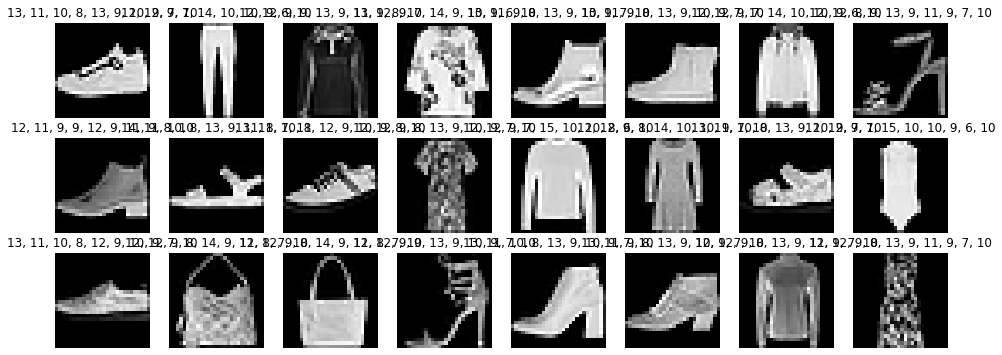

Dev Data Predictions


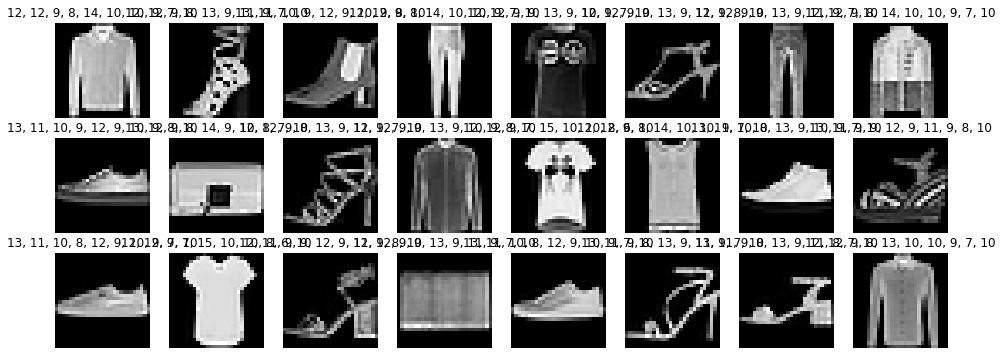

In [11]:
# e.g. test/mnist_model.py

model.eval()
visualize(data_train, model, "Train Data Predictions", "training_preds.png")
visualize(data_dev, model, "Dev Data Predictions", "dev_preds.png")
model.train()

## The Trainer

Having implemented a model, the trainer is the remaining part.
The trainer will fit the model to the dataset and consists of multiple parts.

The loss (+metrics), an optimizer and the trainer itself.

### Loss

In [12]:
# e.g. training/mnist_loss.py
from babilim.training.losses import Loss, SparseCrossEntropyLossFromLogits, SparseCategoricalAccuracy


class FashionMnistLoss(Loss):
    def __init__(self):
        super().__init__()
        self.ce = SparseCrossEntropyLossFromLogits()
        self.ca = SparseCategoricalAccuracy()

    def call(self, y_pred: NetworkOutput, y_true: NetworkOutput) -> ITensor:
        self.log("metrics/ca", self.ca(y_pred.class_id, y_true.class_id).mean())

        return self.ce(y_pred.class_id, y_true.class_id).mean()


# Create the loss (should be in your main function)
loss = FashionMnistLoss()

### Training

In [13]:
# e.g. training/mnist_train.py (contain all stuff annotated with "should be in your main function" and this cell)
from babilim.training.supervised import SupervisedTrainer
from babilim.training.optimizers import SGD
from babilim.training.callbacks import CheckpointCallback
from babilim.training.callbacks import LogCallback
from babilim.training.callbacks import TensorboardCallback
from babilim.training.callbacks import LearningRateUpdateCallback

DEFAULT_CALLBACKS = [
    LogCallback(),
    CheckpointCallback(),
    TensorboardCallback(),
    LearningRateUpdateCallback(config.train_learning_rate_shedule)
]


trainer = SupervisedTrainer(model=model, loss=loss, optimizer=SGD(initial_lr=config.train_learning_rate_shedule.initial_lr), callbacks=DEFAULT_CALLBACKS)
trainer.fit(data_train.to_dataloader(), data_dev.to_dataloader(), config.train_epochs)

[2020-08-04 17:33:13] INFO Started fit.
[2020-08-04 17:33:13] INFO Build Model
[2020-08-04 17:33:14] INFO Trainable Variables:
[2020-08-04 17:33:14] INFO   /linear/0/bn/weight: (1,)
[2020-08-04 17:33:14] INFO   /linear/0/bn/bias: (1,)
[2020-08-04 17:33:14] INFO   /linear/1/weight: (12, 1, 3, 3)
[2020-08-04 17:33:14] INFO   /linear/1/bias: (12,)
[2020-08-04 17:33:14] INFO   /linear/4/bn/weight: (12,)
[2020-08-04 17:33:14] INFO   /linear/4/bn/bias: (12,)
[2020-08-04 17:33:14] INFO   /linear/5/weight: (18, 12, 3, 3)
[2020-08-04 17:33:14] INFO   /linear/5/bias: (18,)
[2020-08-04 17:33:14] INFO   /linear/8/bn/weight: (18,)
[2020-08-04 17:33:14] INFO   /linear/8/bn/bias: (18,)
[2020-08-04 17:33:14] INFO   /linear/9/weight: (18, 18, 3, 3)
[2020-08-04 17:33:14] INFO   /linear/9/bias: (18,)
[2020-08-04 17:33:14] INFO   /linear/12/bn/weight: (18,)
[2020-08-04 17:33:14] INFO   /linear/12/bn/bias: (18,)
[2020-08-04 17:33:14] INFO   /linear/13/weight: (18, 18, 3, 3)
[2020-08-04 17:33:14] INFO   /li

### Visual Inspection

After training it is always important to not only do a numeric evaluation but also a visual inspection of your results.
This is important, because sometimes the numbers do not align with what you actually wanted the model to learn.
Or you had a bug in your implementation.
Visualizations help a lot in finding those errors.

In [14]:
# e.g. test/mnist_model.py

model.eval()
visualize(data_train, model, "Train Data Predictions", "training_preds_final.png")
visualize(data_dev, model, "Dev Data Predictions", "dev_preds_final.png")
model.train()

NameError: name 'model' is not defined